# Time Series Analysis and Forecasting

### What is Time Series? Why use it?

Time series is a sequence of data points that are indexed in time order. Most commonly, this sequence of data points is equally spaced points in time. 

Time series are commonly used in:
<ul>
    <li>1.) Econometrics</li>
    <li>2.) Mathematical Finance</li>
    <li>3.) Weather forecasting</li>
    <li>4.) Earthquake prediction</li>
    <li>5.) Astronomy</li>
</ul>

Analyzing time series is important to understand hidden patterns in data that are associated with time dimension. Time series forecasting uses data modeling to predict some future value or values in time based on previously observed values.

### Time Series Data

The sample data I am using to demonstrate time series pecularities is the one borrowed from Tableau. Its sales data from a fictatious company called <b>Super Store</b>.

### Reading the data

I am going to use pandas library along with its functionality of reading Excel files. The imported data is in Excel in <b>Orders</b> sheet.

In [1]:
import pandas as pd

original_df = pd.read_excel ("C:/Users/IEUser/Desktop/DSProject/sourcedata/sales data.xlsx", sheet_name = "Orders")

### Profiling the data

I am going to use a library call <b>Pandas-Profiling</b>. This library allows quick exploratory data analysis.

In [2]:
import warnings
import pandas_profiling

pandas_profiling.ProfileReport (original_df)

Number of variables,24
Number of observations,51290
Total Missing (%),3.4%
Total size in memory,9.4 MiB
Average record size in memory,192.0 B
Numeric,7
Categorical,15
Boolean,0
Date,2
Text (Unique),0
Rejected,0


### Analyzing the Profile Report

In this data, I am primarily interested in the columns <b>Order Date</b> and <b>Sales</b>. There are other variables that are categorical in nature such as <b>Category</b> and <b>sub category</b>. However, the main aim of this project is to forcast overall sales irrespective of any category.

I am visualizing some trends in data.

#### Visualizing sales data by category

There are three categories of Sales. I am going to create three data frames for each of the category and do plotting by each category.

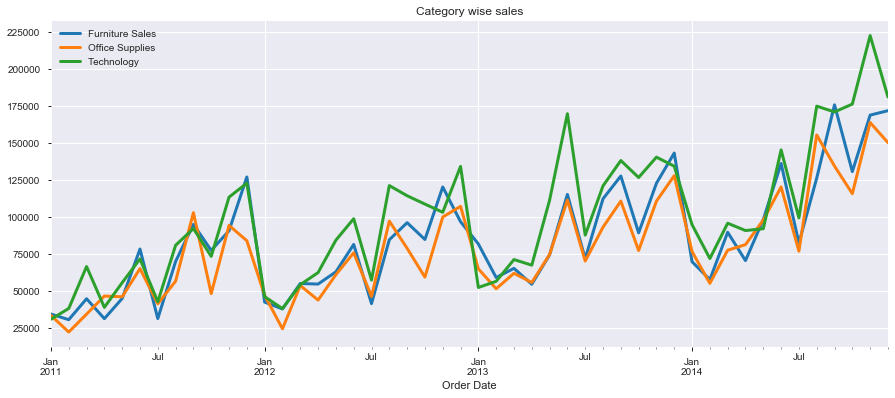

In [9]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.use('TkAgg')

#Category = Furniture
cat_furniture_df = original_df[original_df.Category == "Furniture"]
cat_furniture_df = cat_furniture_df.groupby('Order Date')['Sales'].sum().reset_index()
cat_furniture_df = cat_furniture_df.sort_values('Order Date')
cat_furniture_df = cat_furniture_df.set_index('Order Date')
cat_furniture_df = cat_furniture_df['Sales'].resample('MS').sum()
cat_furniture_df.plot(figsize=(15, 6), label='Furniture Sales', lw=3)

#Category = Office Supplies
cat_officesupplies_df = original_df[original_df.Category == "Office Supplies"]
cat_officesupplies_df = cat_officesupplies_df.groupby('Order Date')['Sales'].sum().reset_index()
cat_officesupplies_df = cat_officesupplies_df.sort_values('Order Date')
cat_officesupplies_df = cat_officesupplies_df.set_index('Order Date')
cat_officesupplies_df = cat_officesupplies_df['Sales'].resample('MS').sum()
cat_officesupplies_df.plot(figsize=(15, 6), label='Office Supplies', lw=3)

#Category = Technology
cat_technology_df = original_df[original_df.Category == "Technology"]
cat_technology_df = cat_technology_df.groupby('Order Date')['Sales'].sum().reset_index()
cat_technology_df = cat_technology_df.sort_values('Order Date')
cat_technology_df = cat_technology_df.set_index('Order Date')
cat_technology_df = cat_technology_df['Sales'].resample('MS').sum()
cat_technology_df.plot(figsize=(15, 6), label='Technology', lw=3)

plt.title("Category wise sales")
plt.legend()
plt.show()

#### Appending all the datasets

In order to develop univariate forecast for sales, I am going to append all three category wise datasets together. But first I will have to transform these three datasets from series to Pandas dataframe.

In [10]:
cat_furniture_df = pd.DataFrame(cat_furniture_df)
cat_officesupplies_df = pd.DataFrame(cat_officesupplies_df)
cat_technology_df = pd.DataFrame(cat_technology_df)

Now its easier to append all three datasets using Pandas append.

In [11]:
appended_df = cat_furniture_df.append(cat_officesupplies_df)
appended_df = appended_df.append(cat_technology_df)

appended_df.describe()

,Sales
count,144.000000
mean,87795.152152
std,39746.982002
min,22276.999000
25%,56368.048200
50%,81413.552050
75%,112582.173680
max,222579.037300


Finally, I will take an aggregate again on dates, so that I have monthly overall sales.

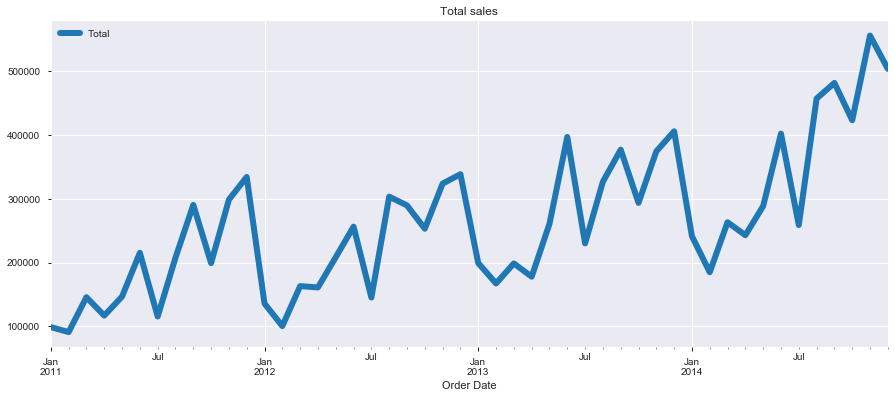

In [12]:
appended_df = appended_df.groupby('Order Date')['Sales'].sum().reset_index()
appended_df = appended_df.sort_values('Order Date')
appended_df = appended_df.set_index('Order Date')
appended_df = appended_df['Sales'].resample('MS').sum()
appended_df.plot(figsize=(15, 6), label='Total', lw=6)

plt.title("Total sales")
plt.legend()
plt.show();

My <b>EDA</b> is finished. Although I could have done a lot more, but for this project, I think its more than enough for forecasting exercise.

### Decomposing the time series

Decomposing the time series will show 3 components of it. The three components are:
<ul>
    <li>1.) Trend </li>
    <li>2.) Seasonality </li>
    <li>3.) Noise </li>
</ul>

I am going to decompose my aggregated and appended dataset using <b>statsmodel.api</b>. This library has a method of decomposition in which I am going to use <b>additive</b> model. The other model is <b>multiplicative</b>.

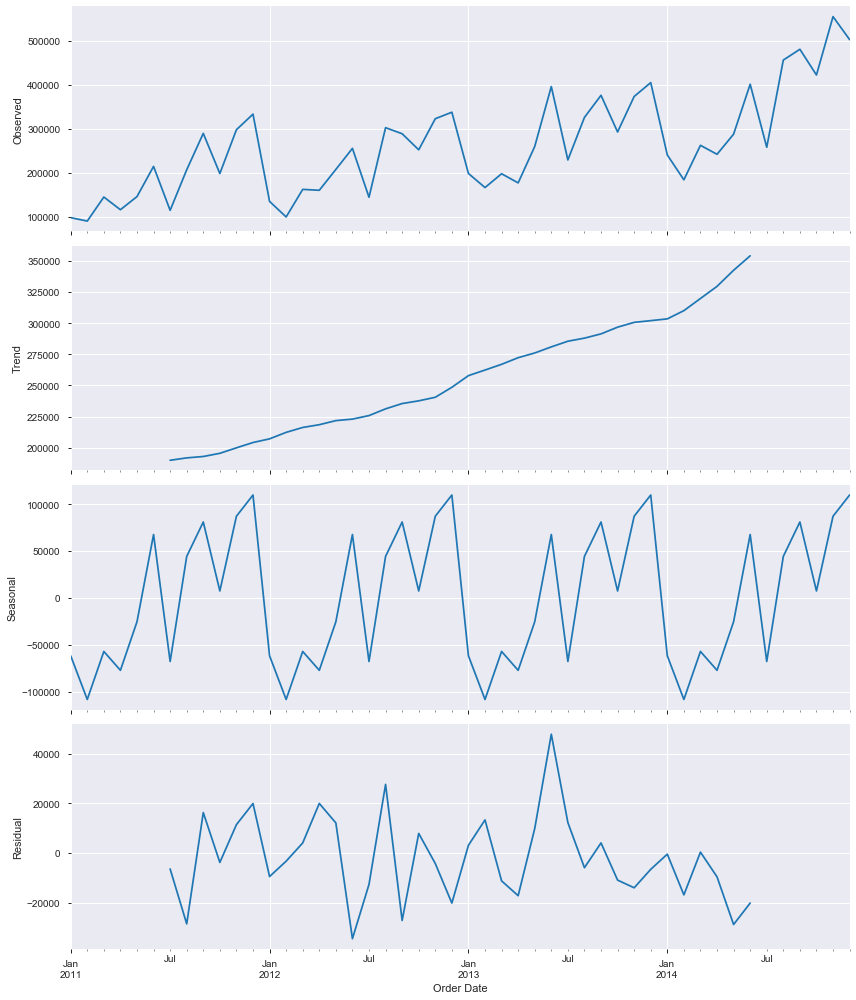

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 14

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(appended_df, model='additive')
fig = decomposition.plot()
plt.show();

Total sales has an inclining trend, with highly visible seasonality.

### Checking for Stationarity

Stationarity is an important concept which allows more meaningful analysis and forecasts. In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. A stationary time series is usually very simple to model and hence easier to implement as a process.

I am going to check stationarity of my data using <b>adfuller</b> test in <b>statsmodels.tsa.stattools</b>.

In [18]:
from statsmodels.tsa.stattools import adfuller
appended_df = pd.DataFrame(appended_df)
result = adfuller(appended_df['Sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.618332
p-value: 0.988059


Since p-value is greater than 0.05, I fail to reject the null hypothesis that my time series is stationary.

### Setting up SARIMAX grid search

SARIMAX stands for <b>S</b>easonal <b>A</b>uto <b>R</b>egressive <b>I</b>ntegrated <b>M</b>oving <b>A</b>verage e<b>X</b>ogenous method for forecasting. <b>Auto Regressive</b> means that the next value of data in the next time period is dependent on the previous value of the previous time period.

In [20]:
# setting up grid parameters
import warnings
warnings.filterwarnings("ignore")

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# grid searching for optimal set of parameters
params_df = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(appended_df,
                                              order = param,
                                              seasonal_order = param_seasonal,
                                              enforce_stationarity = False,
                                              enforce_invertibility = False)
            results = model.fit()
            print("ARIMA{} x {} - AIC:{}".format(param, param_seasonal, results.aic))
            params_df.append({'param':param, 'param_seasonal':param_seasonal, 'aic':results.aic})
        except:
            continue
# saving the parameters for the minimum value of AIC
params_df = pd.DataFrame(params_df)
params_df = params_df.loc[params_df['aic'].idxmin()]

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC:1317.4111091425168
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC:513537.25798190414
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC:885.2017301877736
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC:869.7843438155486
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC:845.7811563138702
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC:603.5868127784067
ARIMA(0, 0, 1) x (0, 0, 0, 12) - AIC:1263.2388804614502
ARIMA(0, 0, 1) x (0, 0, 1, 12) - AIC:483681.9377406934
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC:844.8068332412823
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC:979.3764761603005
ARIMA(0, 0, 1) x (1, 0, 1, 12) - AIC:927.1863532846191
ARIMA(0, 0, 1) x (1, 1, 0, 12) - AIC:598.3562914861543
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:1183.425588497629
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:96255.50731993062
ARIMA(0, 1, 0) x (0, 1, 0, 12) - AIC:831.6460902564795
ARIMA(0, 1, 0) x (1, 0, 0, 12) - AIC:854.6872587625707
ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC:56972.93256809913
ARIMA(0, 1, 0) x (1, 1, 0, 12) - AIC:551.2421699394123
ARIMA(0

The <b>params_df</b> stores the parameters against the lowest AIC value.

Next I am going to build SARIMAX model using the stored parameters.

In [21]:
mod = sm.tsa.statespace.SARIMAX(appended_df,
                                order=params_df["param"],
                                seasonal_order=params_df["param_seasonal"],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit( disp = 0 )
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -262.373
Date:                            Tue, 04 Jun 2019   AIC                            530.746
Time:                                    00:37:50   BIC                            534.019
Sample:                                01-01-2011   HQIC                           531.517
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2814      0.277     -1.017      0.309      -0.824       0.261
ar.S.L12      -0.7405      0.287   

I prefer to visualize these results.

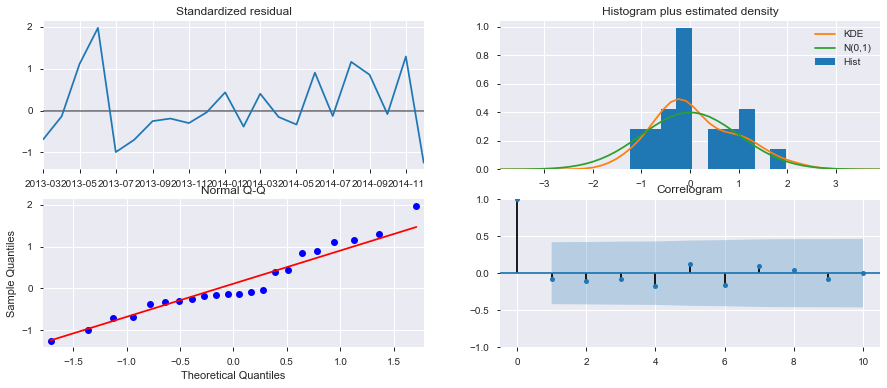

In [22]:
# viewing the diagnostic graphs
results.plot_diagnostics(figsize=(15, 6))
plt.show()

Residual errors seem to be randomly distrbuted which is a very good sign that my model's residuals follows "normal" distribution.

### Testing the model returned values against the actual data

Best way to test my model is to do a visual inspection. I will be plotting "modeled" values over actual values.

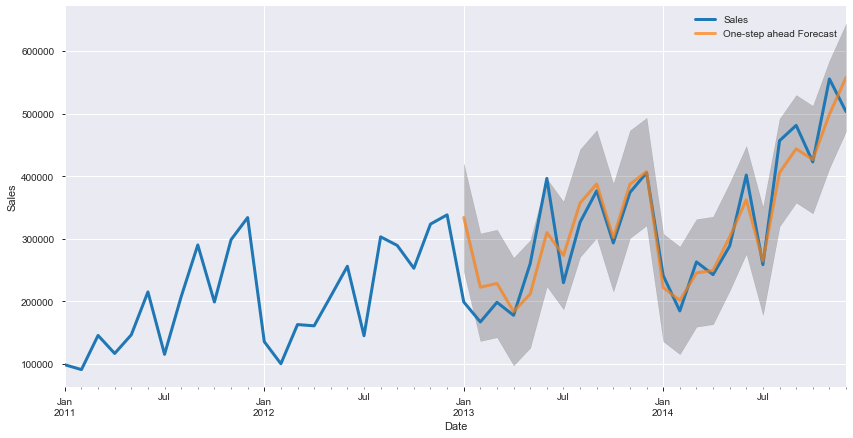

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = appended_df["2011":].plot(label='observed', lw=3)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7), lw=3)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show();

The modeled data seems to closely follow the actual data. 

### Forecasting the data

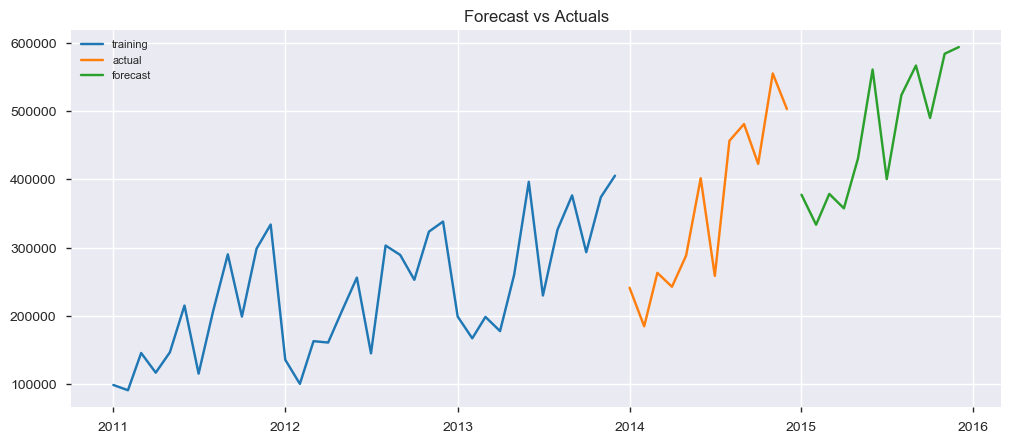

In [24]:
rows = appended_df.shape[0]
testrows = int(0.25*rows)
trainrows = rows - testrows

train_df = appended_df.iloc[0:trainrows]
test_df = appended_df.iloc[trainrows : testrows + trainrows]

fc = results.forecast(12)
conf = results.conf_int(alpha = 0.1) #90% confidence

# Make as pandas series
fc_df = pd.DataFrame(fc)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')

plt.plot(test_df, label='actual')

plt.plot(fc_df, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Accuracy of My model

Most commonly used matric to measure accuracy is <b>M</b>ean <b>A</b>bsolute <b>P</b>ercentage <b>E</b>rror. 

In [26]:
import numpy as np
fc_df.columns = ['Sales']
expected = test_df['Sales'].tolist()
predictions = fc_df['Sales'].tolist()

mape = np.mean(np.abs(np.asarray(predictions) - np.asarray(expected))/np.abs(np.asarray(expected)))
accuracy=(1-mape)*100
print("The forecast of the next 12 months have average accuracy of {}%".format(round(accuracy,2)))

The forecast of the next 12 months have average accuracy of 63.03%
